In [369]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
import statsmodels.formula.api as smf
import statsmodels.api as sm

Simulate age as a confounder where younger persons are less likely to be 
treated, and age increases the risk for the outcome.

In [370]:
# set seed
np.random.seed(12345)
# sample size
n = 1000

# random distribution of age mean 55, sd = 10
age = np.random.normal(loc = 55, scale = 10, size = n)
# age affects probability of treatment (increase) over baseline trt proportion of 0.5
c_trt = ( 1 / ( 1 + np.exp( -(5.0 + age * -0.1 ) ) ) )

# trt association
trt = np.random.binomial(n = 1, p = c_trt, size = n)

# true trt effect
trt_effect = np.log( 0.5 )
# outcome associaiton, binary outcome event rate of 0.5
c_out = ( 1 / ( 1 + np.exp( -(-3.0 + age * 0.05 + trt * trt_effect ) ) ) )

# outcome
outcome = np.random.binomial(n = 1, p = c_out, size = n)

# dataframe
df = pd.DataFrame({'outcome': outcome, 'age': age , 'trt': trt})

df.describe()

,outcome,age,trt
count,1000.000000,1000.000000,1000.000000
mean,0.397000,54.976493,0.413000
std,0.489521,9.799564,0.492619
min,0.000000,25.506565,0.000000
25%,0.000000,48.163293,0.000000
50%,0.000000,54.899264,0.000000
75%,1.000000,61.302301,1.000000
max,1.000000,94.275280,1.000000


Crude model.

In [371]:
mod = LogisticRegression( penalty='none' , max_iter = 1000)
mod.fit(X = df[['trt']] , y = df['outcome'])

names = ['trt']
odds_ratio = np.round( np.exp( mod.coef_ ), 2 )

pd.DataFrame({'variable': names, 'odds_ratio': odds_ratio[0] })

,variable,odds_ratio
0,trt,0.41


Adjusted model.

In [372]:
mod = LogisticRegression( penalty='none' , max_iter = 1000)
mod.fit(X = df[['age', 'trt']] , y = df['outcome'])

names = ['age', 'trt']
odds_ratio = np.round( np.exp( mod.coef_ ), 2 )

pd.DataFrame({'variable': names, 'odds_ratio': odds_ratio[0] })

,variable,odds_ratio
0,age,1.07
1,trt,0.62


Calculating weights based on propensity score. 

IPTW = Inverse probability of treatment weight

ATE = Average treatment effect

ATT = Average treatment in the treated

There are others like ATM and ATO that I won't calculate since ATT is usually
pretty close to these two.

In [373]:
# pscore mode
p_mod = LogisticRegression( penalty='none' , max_iter = 1000)
p_mod.fit(X = df[['age']] , y = df['trt'])

# estimate propensity score
p_score = p_mod.predict_proba( df[['age']] )[:, 1]
# find treated p score
df['p_score'] = p_score

# treatment vector used later in some other weighting schemes
treatment = df['trt']

# calculate IPTW
iptw = 1 / p_score

# calculate average treatment effect (ATE) weight
w_ate = (treatment / p_score) + ((1 - treatment) / (1 - p_score))

# calculate average treatment effect among treated (ATT) weight 
w_att = (
    ( ( p_score * treatment) / p_score ) +
    ( (p_score * (1 - treatment) ) / (1 - p_score) )
    )

# mask
mask = df['trt'] == 1

# propensity and weights for treated
p_trt = p_score[mask]
iptw_trt = iptw[mask]
ate_trt = w_ate[mask]
att_trt = w_att[mask]

# propensity and weights for no treat
p_no_trt = p_score[~mask]
iptw_no_trt = iptw[~mask]
ate_no_trt = w_ate[~mask]
att_no_trt = w_att[~mask]

Mirror plot checking propensity balance using inverse probability of 
treatment weighting (IPTW). Not great balance with counfound by age.

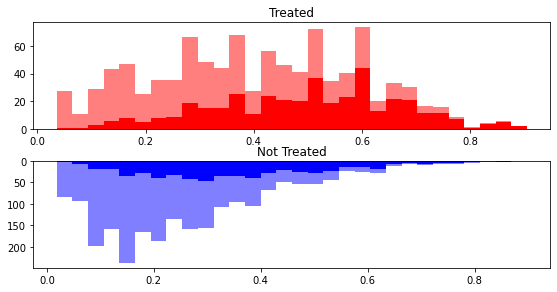

In [374]:
# plot of propensity in treated and non-treated
fig, ( ax1, ax2 ) = plt.subplots( 2, figsize = ( 8, 4 ) )
fig.tight_layout()
# Treated
# before weight
ax1.hist(p_trt, bins = 30, color = 'red', alpha = 1) 
# after weight
ax1.hist(p_trt, bins = 30, color = 'red', alpha = 0.5, weights = iptw_trt) 
ax1.title.set_text('Treated')
# Not treated 
# before weight
ax2.hist(p_no_trt, bins = 30, color = 'blue', alpha = 1.0)
# after weight
ax2.hist(p_no_trt, bins = 30, color = 'blue', alpha = 0.5, weights = iptw_no_trt)
ax2.title.set_text('Not Treated')
ax2.invert_yaxis()
plt.show();

ATE (marginal population level effect).

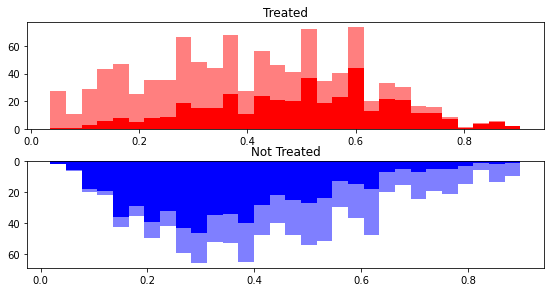

In [375]:
# plot of propensity in treated and non-treated
fig, ( ax1, ax2 ) = plt.subplots( 2, figsize = ( 8, 4 ) )
fig.tight_layout()
# Treated
# before weight
ax1.hist(p_trt, bins = 30, color = 'red', alpha = 1) 
# after weight
ax1.hist(p_trt, bins = 30, color = 'red', alpha = 0.5, weights = ate_trt) 
ax1.title.set_text('Treated')
# Not treated 
# before weight
ax2.hist(p_no_trt, bins = 30, color = 'blue', alpha = 1.0)
# after weight
ax2.hist(p_no_trt, bins = 30, color = 'blue', alpha = 0.5, weights = ate_no_trt)
ax2.title.set_text('Not Treated')
ax2.invert_yaxis()
plt.show();

ATT leaves the treatment group propensity score alone but weights the 
non-treated group to be similar to treated group based on covariates (age).

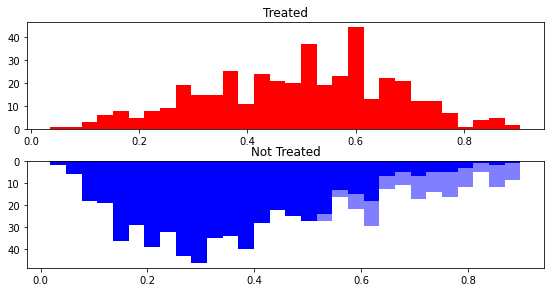

In [376]:
# plot of propensity in treated and non-treated
fig, ( ax1, ax2 ) = plt.subplots( 2, figsize = ( 8, 4 ) )
fig.tight_layout()
# Treated
# before weight
ax1.hist(p_trt, bins = 30, color = 'red', alpha = 1) 
# after weight
ax1.hist(p_trt, bins = 30, color = 'red', alpha = 0.5, weights = att_trt) 
ax1.title.set_text('Treated')
# Not treated 
# before weight
ax2.hist(p_no_trt, bins = 30, color = 'blue', alpha = 1.0)
# after weight
ax2.hist(p_no_trt, bins = 30, color = 'blue', alpha = 0.5, weights = att_no_trt)
ax2.title.set_text('Not Treated')
ax2.invert_yaxis()
plt.show();

Estimating IPTW, ATE, ATT. Note, not using robust variance so CIs might be off.

In [377]:
# ATE model, doubly robust (kinda) with age in it
ate_glm = smf.glm(
    "outcome ~ trt",
    data=df,
    family=sm.families.Binomial(),
    freq_weights=np.asarray(w_ate),
)

ate_res = ate_glm.fit()



# ATT model, doubly robust (kinda) with age in it
att_glm = smf.glm(
    "outcome ~ trt",
    data=df,
    family=sm.families.Binomial(),
    freq_weights=np.asarray(w_att),
)

att_res = att_glm.fit()



Closest estimate is ATT. Can't quite recover true effect but there is a
group in the untreated that aren't represented in the treated. Likely
younger persons. 

In [378]:
# ate treat effect and 95% CI
ate_est = np.round( np.exp( ate_res.params['trt'] ), 2 )
ate_lower_95 = np.round( np.exp( ate_res.conf_int().iloc[1, 0] ) , 2)
ate_upper_95 = np.round( np.exp( ate_res.conf_int().iloc[1, 1] ) , 2 )

# att treat effect and 95% CI
att_est = np.round( np.exp( att_res.params['trt'] ), 2 )
att_lower_95 = np.round( np.exp( att_res.conf_int().iloc[1, 0] ) , 2)
att_upper_95 = np.round( np.exp( att_res.conf_int().iloc[1, 1] ) , 2 )

# results
pd.DataFrame(
    {
        'Type': ['ATE', 'ATT'],
        'estimate': [ate_est, att_est],
         'lower_95': [ate_lower_95, att_lower_95], 
         'upper_95': [ate_upper_95, att_upper_95]
    }
)

,Type,estimate,lower_95,upper_95
0,ATE,0.71,0.59,0.85
1,ATT,0.68,0.50,0.91


In [379]:
# balanced model
bal_mod = LogisticRegression( penalty='none' , class_weight = 'balanced',  max_iter = 1000)
bal_mod.fit(X = df[['age']] , y = df['trt'])
# predicted prob
bal_prob = bal_mod.predict_proba( df[['age']] )

Plot of balanced weights based using sklearn option to balance classes. 

The class-balanced probabilities look more or less the same as the histograms
for the weighted probabilities of the IPTW or ATE above. But what happens
when you put it in a weighted model? 

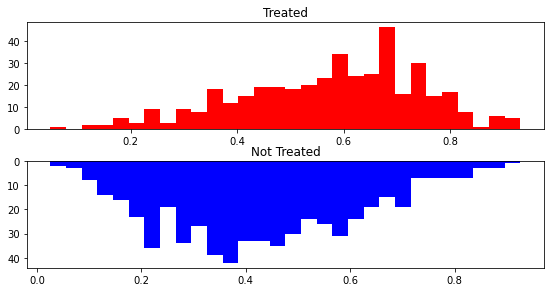

In [380]:
# plot of propensity in treated and non-treated
fig, ( ax1, ax2 ) = plt.subplots( 2, figsize = ( 8, 4 ) )
fig.tight_layout()
# Treated
# before weight
ax1.hist(bal_prob[:, 1][mask], bins = 30, color = 'red', alpha = 1) 
# after weight
ax1.title.set_text('Treated')
# Not treated 
# before weight
ax2.hist(bal_prob[:, 1][~mask], bins = 30, color = 'blue', alpha = 1.0)
ax2.title.set_text('Not Treated')
ax2.invert_yaxis()
plt.show();

In [391]:
# balanced model, doubly robust (kinda) with age in it
b_glm = smf.glm(
    "outcome ~ trt ",
    data=df,
    family=sm.families.Binomial(),
    freq_weights=np.asarray(bal_prob[:, 1]), # not sure how to use a balanced probability in a model???
)

b_res = b_glm.fit()


In [390]:
# att treat effect and 95% CI
b_est = np.round( np.exp( b_res.params['trt'] ), 2 )
b_lower_95 = np.round( np.exp( b_res.conf_int().iloc[1, 0] ) , 2)
b_upper_95 = np.round( np.exp( b_res.conf_int().iloc[1, 1] ) , 2 )

# results
pd.DataFrame(
    {
        'Type': ['ATE', 'ATT', 'sklearn balanced'],
        'estimate': [ate_est, att_est, b_est],
         'lower_95': [ate_lower_95, att_lower_95, b_lower_95], 
         'upper_95': [ate_upper_95, att_upper_95, b_upper_95]
    }
)

,Type,estimate,lower_95,upper_95
0,ATE,0.71,0.59,0.85
1,ATT,0.68,0.50,0.91
2,sklearn balanced,0.43,0.36,0.51


First none of these models is very good at recovering the true effect since
there is not great overlap in the untreated group. Can add in age as a covariate
for a 'doubly robust' model. 

A couple thoughts on the balanced probability from sklearn:

Predicted probability of treatment is weighted using IPTW, but it is a weighted
probability of the treatment and not the outcome. This is not what we want
when we estimate 'causal models'. 

In order to use weighting schemes in Rubin type causal models (potential outcomes)
frame work, you'd need to backtransform the probability 
(probably using bayes rule based on proportion treated)
to use them as weights in a model. I don't think this is ideal.

Also wouldn't be able to use different weighting schemes like ATT or ATM without
backtransforming. Also another issue would be if you wanted to propensity-match
using nearest neighbor, probablities are now weighted by treatment, so a 
probility of being treated in the treated group of 0.6 will mean something 
different than the probablity of being treated of 0.6 in the not treated group.

In summary, I don't recommend using the balanced option in sklearn. Way too many
issues.